<a href="https://colab.research.google.com/github/DavisRayM/msft-stock-prediction/blob/main/msft-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Author: Davis Muro

For CPSC 5610

Microsoft Stock Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input, BatchNormalization, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from typing import Tuple, List
import matplotlib.dates as mdates
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
np.random.seed(25)
tf.random.set_seed(25)

## Preprocessing

In [4]:
df = pd.read_csv('data/MSFT.csv', parse_dates=['Date'], index_col='Date')

# Sort dataframe by `Date` (Ascending)
df.sort_index(inplace=True)

# Drop Adj Close
df.drop(columns=['Adj Close'], inplace=True)

df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [5]:
df['Open'].max(), df['High'].max(), df['Low'].max(), df['Close'].max(), df['Volume'].max()

(338.51001, 338.790009, 334.420013, 336.440002, 111242100)

In [6]:
df.shape

(1259, 5)

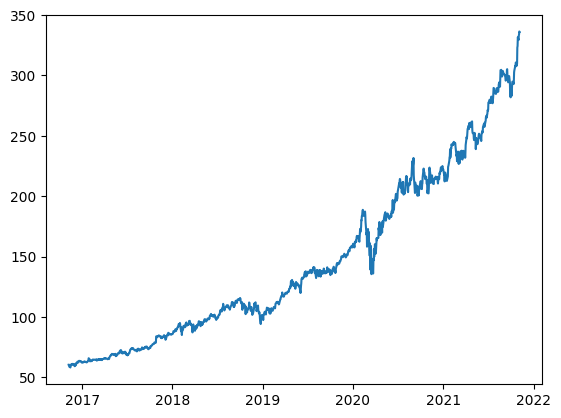

In [7]:
plt.plot(df.index, df['Close'])

In [8]:
scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume']

def scale_features(df):
  df = df.copy(deep=True)

  df[features[:4]] = scaler.fit_transform(df[features[:4]])
  df[features[4:]] = volume_scaler.fit_transform(df[features[4:]])

  return df

normalized = scale_features(df)
normalized.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [9]:
normalized['Open'].max(), normalized['High'].max(), normalized['Low'].max(), normalized['Close'].max(), normalized['Volume'].max()

(1.0, 1.0, 0.9999999999999999, 1.0, 1.0)

In [10]:
normalized.shape

(1259, 5)

## Windowing

In [11]:
def inverse_scale(predictions):
    prices_scaled = predictions[:, :4]
    volume_scaled = predictions[:, 4:]

    prices_unscaled = scaler.inverse_transform(prices_scaled)
    volume_unscaled = volume_scaler.inverse_transform(volume_scaled)

    # concatenate back into a single array (num_steps, 5)
    unscaled = np.concatenate([prices_unscaled, volume_unscaled], axis=1)
    return unscaled

In [12]:
train_size = normalized.shape[0] * 80 // 100
test_size = normalized.shape[0] - train_size
dates_train = df.index[:train_size]
dates_val = df.index[train_size:]
train_size, test_size

(1007, 252)

In [13]:
def window(df, n_steps, batch_size, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(df)
    ds = ds.window(n_steps + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(n_steps + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
      ds = ds.shuffle(10000).batch(batch_size).prefetch(1)
    else:
      ds = ds.batch(batch_size).prefetch(1)
    return ds

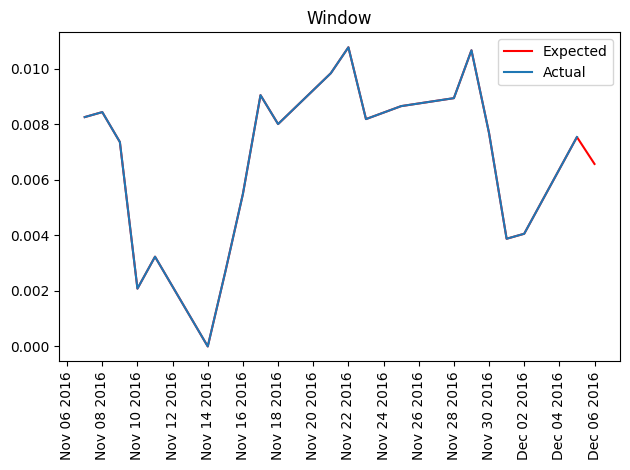

Num batches: 99


In [14]:
timesteps = 20
batch_size = 10

train = window(normalized[:train_size], timesteps, batch_size)
for (X, y) in train.take(1):
  full_sequence = np.append(X[0, :, 3].numpy(), y[0, 3].numpy())
  plt.plot(dates_train[:21], full_sequence, label="Expected", color='red')
  plt.plot(dates_train[:20], X[0, :, 3].numpy(), label='Actual')
  plt.title("Window")
  plt.legend()
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

train = window(normalized[:train_size], timesteps, batch_size, shuffle=True)
print("Num batches:", len(list(train)))

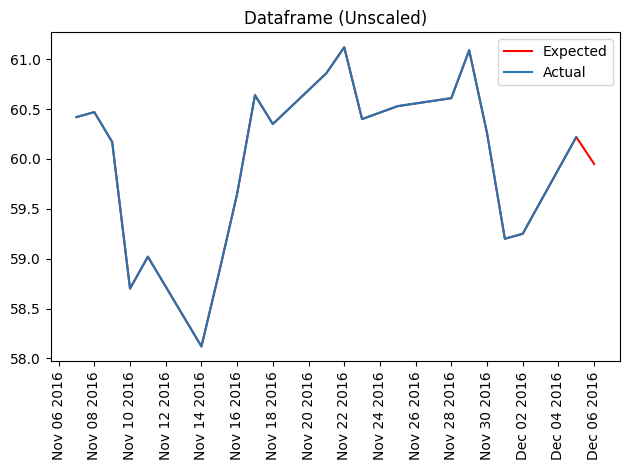

In [15]:
plt.plot(dates_train[:21], df.iloc[:21, 3], label="Expected", color='red')
plt.plot(dates_train[:20], df.iloc[:20, 3], label="Actual")
plt.legend()
plt.title("Dataframe (Unscaled)")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
test = window(normalized[train_size:], timesteps, batch_size, shuffle=True)

## Modelling

In [17]:
class BatchNormSimpleRNN(Layer):
    def __init__(self, units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.simple_rnn = SimpleRNN(
            units,
            activation=None,
            return_sequences=return_sequences,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            **kwargs
        )
        self.batch_norm = BatchNormalization()
        self.activation_fn = activations.get(activation)

    def call(self, inputs, training=None):
        x = self.simple_rnn(inputs, training=training)
        x = self.batch_norm(x, training=training)
        return self.activation_fn(x)

In [18]:
def create_model(kind: str = "simple", input_shape: Tuple[int, int] = (timesteps, 5), neurons: int = 64):
  model = tf.keras.models.Sequential()
  model.add(Input(shape=input_shape))

  if kind == "simple":
    model.add(BatchNormSimpleRNN(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "lstm":
    model.add(LSTM(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "gru":
    model.add(GRU(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  else:
    assert False, "Unsupported kind: " + kind

  model.add(Dense(32, activation="relu"))
  model.add(Dense(input_shape[1]))
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])
  return model

In [19]:
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

lr_scheduling = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

epochs = 30

### Simple RNN

Uses SimpleRNN + Batch normalization layers with 1 hidden layer.

In [20]:
simple_checkpoint_path = "drive/MyDrive/models/simple_cp.weights.h5"
checkpoint_dir = os.path.dirname(simple_checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simple_checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_mae',
                                                 mode='min',
                                                 save_best_only=True,
                                                 verbose=1)

In [21]:
simple = create_model(kind="simple")
simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn           │ (None, 64)             │         4,736 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,981 (27.27 KB)

 Trainable params: 6,853 (26.77 KB)

 Non-trainable params: 128 (512.00 B)

In [22]:
simple.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping, lr_scheduling, cp_callback])

Epoch 1/30
     89/Unknown 5s 5ms/step - loss: 0.2819 - mae: 0.3934

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 0.35640, saving model to drive/MyDrive/models/simple_cp.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2688 - mae: 0.3826 - val_loss: 0.1673 - val_mae: 0.3564 - learning_rate: 0.0010
Epoch 2/30
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0668 - mae: 0.1989
Epoch 2: val_mae did not improve from 0.35640
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0664 - mae: 0.1983 - val_loss: 0.2258 - val_mae: 0.4243 - learning_rate: 0.0010
Epoch 3/30
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0452 - mae: 0.1614
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_mae did not improve from 0.35640
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0451 - mae: 0.1612 - val_loss: 0.1781 - val_mae: 0.3803 - learning_rate: 0.0010
Epoch 4/30
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0352 - mae: 0.1454
Epoch 4: val_mae did not improve from 0.35640
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0352

In [23]:
result = pd.DataFrame(simple.history.history)
result.head()

,loss,mae,val_loss,val_mae,learning_rate
0,0.158849,0.291086,0.167273,0.356403,0.0010
1,0.059601,0.187889,0.225798,0.424266,0.0010
2,0.041426,0.154650,0.178052,0.380278,0.0010
3,0.034140,0.142627,0.220611,0.424102,0.0005
4,0.029193,0.131595,0.198284,0.402056,0.0005


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

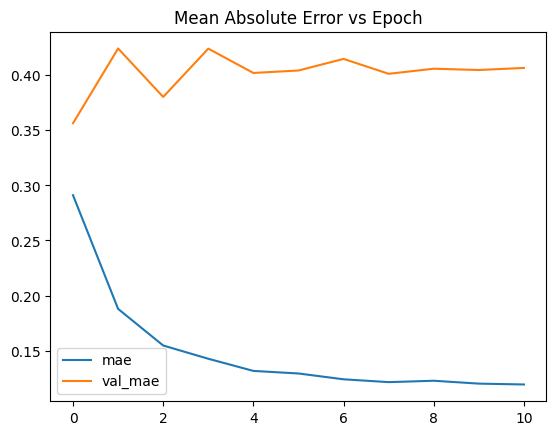

In [24]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

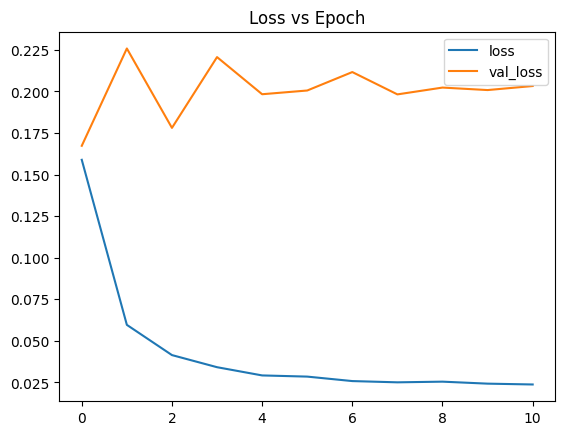

In [25]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### GRU Model

Uses a GRU layer with one hidden layer.

In [26]:
gru_checkpoint_path = "drive/MyDrive/models/gru_cp.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=gru_checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_mae',
                                                 mode='min',
                                                 save_best_only=True,
                                                 verbose=1)

In [27]:
gru = create_model(kind="gru")
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,877 (62.02 KB)

 Trainable params: 15,877 (62.02 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
gru.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping, lr_scheduling, cp_callback])

Epoch 1/30
     98/Unknown 6s 25ms/step - loss: 0.0232 - mae: 0.0991

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 0.11883, saving model to drive/MyDrive/models/gru_cp.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0229 - mae: 0.0986 - val_loss: 0.0160 - val_mae: 0.1188 - learning_rate: 0.0010
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059 - mae: 0.0529
Epoch 2: val_mae improved from 0.11883 to 0.10958, saving model to drive/MyDrive/models/gru_cp.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0059 - mae: 0.0528 - val_loss: 0.0141 - val_mae: 0.1096 - learning_rate: 0.0010
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 - mae: 0.0479
Epoch 3: val_mae did not improve from 0.10958
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0054 - mae: 0.0479 - val_loss: 0.0241 - val_mae: 0.1452 - learning_rate: 0.0010
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - mae: 0.0415
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_mae did not improve from 

In [29]:
result = pd.DataFrame(gru.history.history)
result.head()

,loss,mae,val_loss,val_mae,learning_rate
0,0.011464,0.069768,0.015952,0.118834,0.0010
1,0.005409,0.050100,0.014142,0.109580,0.0010
2,0.005477,0.047375,0.024147,0.145202,0.0010
3,0.003908,0.039280,0.024856,0.149603,0.0010
4,0.003384,0.032655,0.026117,0.150622,0.0005


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

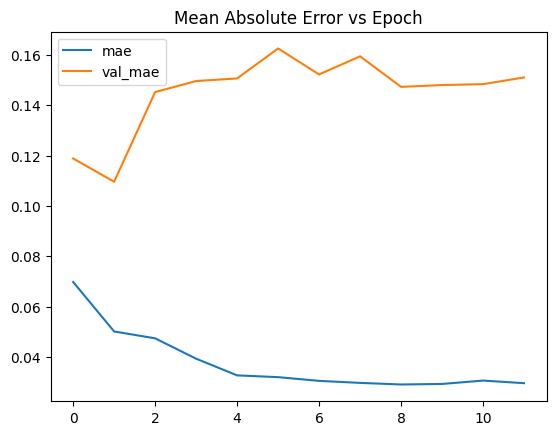

In [30]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

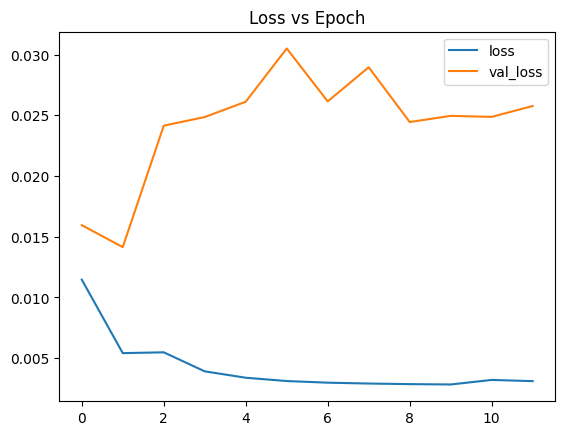

In [31]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### LSTM

Uses LSTM layers with 1 hidden layer.

In [32]:
lstm_checkpoint_path = "drive/MyDrive/models/lstm_cp.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_mae',
                                                 mode='min',
                                                 save_best_only=True,
                                                 verbose=1)

In [33]:
lstm = create_model(kind="lstm")
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 20,165 (78.77 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
lstm.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping, lr_scheduling, cp_callback])

Epoch 1/30
     99/Unknown 6s 19ms/step - loss: 0.0211 - mae: 0.0999

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 0.08511, saving model to drive/MyDrive/models/lstm_cp.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0210 - mae: 0.0996 - val_loss: 0.0095 - val_mae: 0.0851 - learning_rate: 0.0010
Epoch 2/30
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - mae: 0.0527
Epoch 2: val_mae did not improve from 0.08511
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0062 - mae: 0.0526 - val_loss: 0.0185 - val_mae: 0.1241 - learning_rate: 0.0010
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047 - mae: 0.0424
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_mae did not improve from 0.08511
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0047 - mae: 0.0424 - val_loss: 0.0213 - val_mae: 0.1375 - learning_rate: 0.0010
Epoch 4/30
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035 - mae: 0.0357
Epoch 4: val_mae did not improve from 0.08511
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0

In [35]:
result = pd.DataFrame(lstm.history.history)
result.head()

,loss,mae,val_loss,val_mae,learning_rate
0,0.010879,0.069920,0.009524,0.085112,0.0010
1,0.005631,0.049320,0.018463,0.124150,0.0010
2,0.004628,0.042803,0.021273,0.137528,0.0010
3,0.003583,0.035416,0.025366,0.150610,0.0005
4,0.003336,0.032676,0.022394,0.140061,0.0005


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

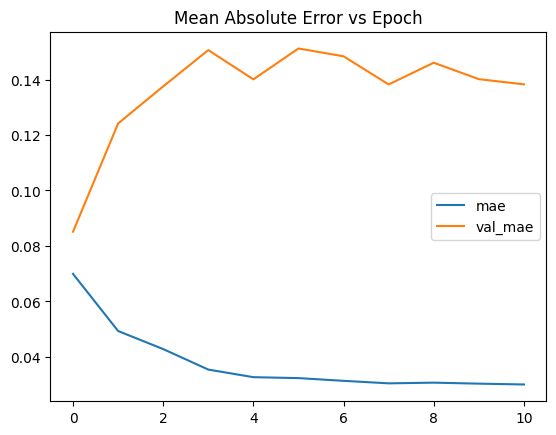

In [36]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

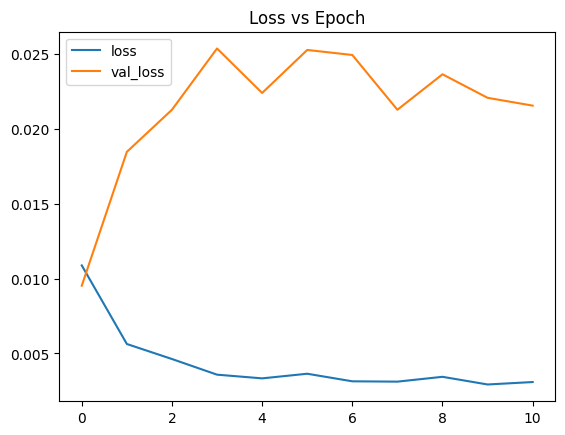

In [37]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

## Evaluation

In [38]:
def predict_range(model, start_date, days):
  end_idx = df.index.get_loc(start_date)
  input = df.iloc[end_idx - timesteps:end_idx]

  scale_features(input) # (20, 5)
  input = np.expand_dims(input, axis=0) # (1, 20, 5)

  predictions = []
  for _ in days:
    pred = model.predict(input)
    predictions.append(inverse_scale(pred)[0])
    input = np.concatenate([input[:, 1:, :], np.expand_dims(pred, axis=1)], axis=1)

  frame = pd.DataFrame(predictions, columns=df.columns, index=days)
  return frame

In [39]:
def prediction_plot_feature(feature, predictions, pred_dates):
  plt.plot(pred_dates[1:], predictions[feature][1:], label="Predicted", linestyle="--")
  plt.title(f"{feature} - Predicted (11/08/2021 - 11/19/2021)")
  plt.legend()
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
  plt.xticks(rotation=90)
  plt.show()

def actual_vs_pred_plot_feature(feature, actual_data, predictions, pred_dates):
  plt.plot(pred_dates, actual_data[[feature]], label="Actual")
  plt.plot(pred_dates, predictions[[feature]], label="Predicted")
  plt.legend()
  plt.title(f"Actual vs Predicted ({feature})")
  plt.legend()
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
  plt.xticks(rotation=90)
  plt.show()

In [40]:
def evaluate_predictions(actual, pred, feature):
    mae = mean_absolute_error(actual[[feature]], pred[[feature]])
    mse = mean_squared_error(actual[[feature]], pred[[feature]])
    return {'MAE': mae, 'MSE': mse}

In [41]:
def load_latest_checkpoint(model):
    return os.path.join(checkpoint_dir, f"{model}_cp.weights.h5")

simple = create_model("simple")
gru = create_model("gru")
lstm = create_model("lstm")

simple.load_weights(load_latest_checkpoint("simple"))
gru.load_weights(load_latest_checkpoint("gru"))
lstm.load_weights(load_latest_checkpoint("lstm"))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
simple.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn_1         │ (None, 64)             │         4,736 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,981 (27.27 KB)

 Trainable params: 6,853 (26.77 KB)

 Non-trainable params: 128 (512.00 B)

In [43]:
gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,877 (62.02 KB)

 Trainable params: 15,877 (62.02 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 20,165 (78.77 KB)

 Non-trainable params: 0 (0.00 B)

#### Simple RNN

In [45]:
pred_dates = dates_val[:21]
actual_data = df.loc[pred_dates]
predictions = predict_range(simple, pred_dates[0], pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


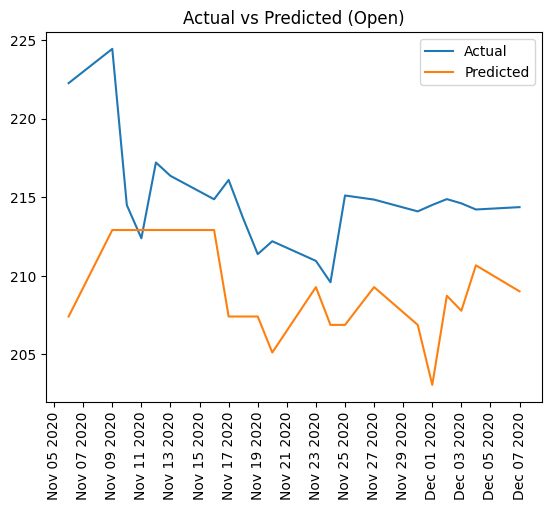

In [46]:
actual_vs_pred_plot_feature('Open', actual_data, predictions, pred_dates)

In [47]:
evaluate_predictions(actual_data, predictions, 'Open')

{'MAE': 5.851994914620538, 'MSE': 47.06550130655938}

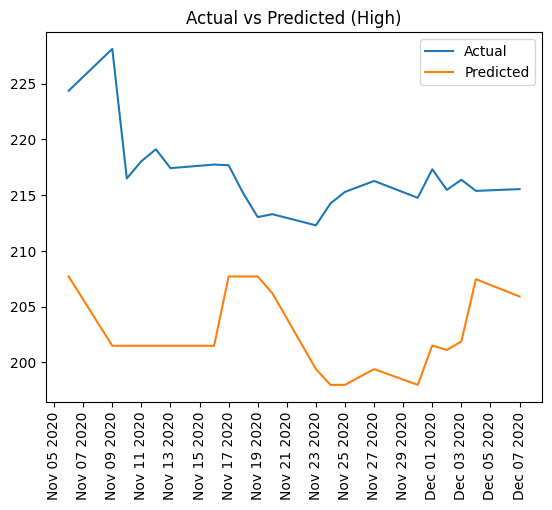

In [48]:
actual_vs_pred_plot_feature('High', actual_data, predictions, pred_dates)

In [49]:
evaluate_predictions(actual_data, predictions, 'High')

{'MAE': 14.135673105143232, 'MSE': 222.2293490825369}

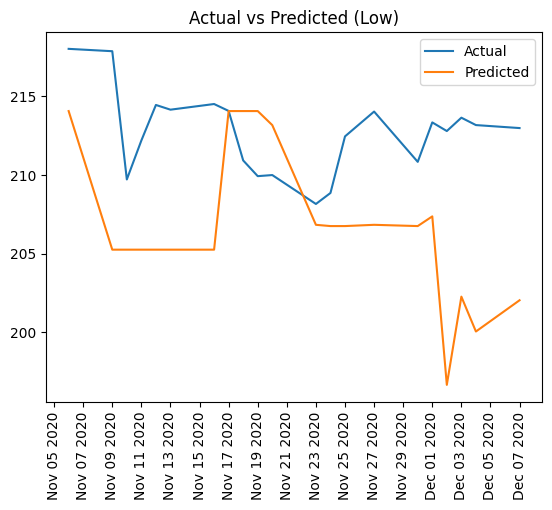

In [50]:
actual_vs_pred_plot_feature('Low', actual_data, predictions, pred_dates)

In [51]:
evaluate_predictions(actual_data, predictions, 'Low')

{'MAE': 6.851581401832218, 'MSE': 64.59612453201419}

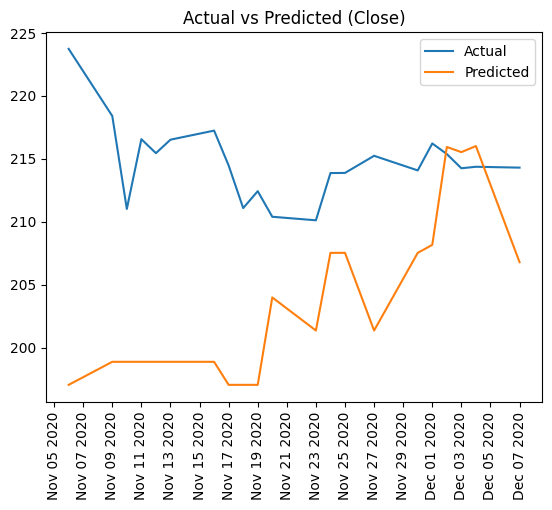

In [52]:
actual_vs_pred_plot_feature('Close', actual_data, predictions, pred_dates)

In [53]:
evaluate_predictions(actual_data, predictions, 'Close')

{'MAE': 11.555182362769717, 'MSE': 179.50651191132144}

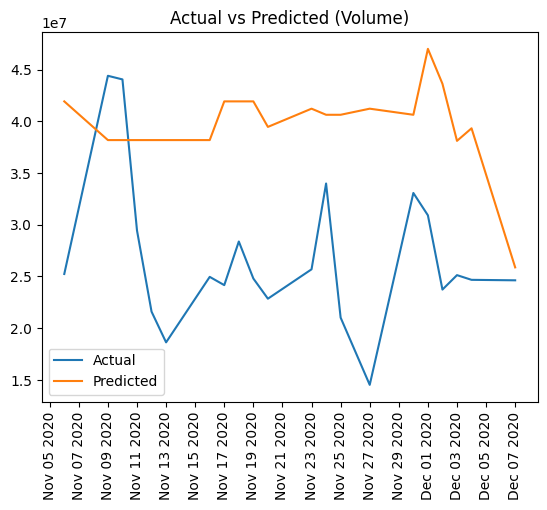

In [54]:
actual_vs_pred_plot_feature('Volume', actual_data, predictions, pred_dates)

In [55]:
evaluate_predictions(actual_data, predictions, 'Volume')

{'MAE': 13946020.285714285, 'MSE': 229003813986889.34}

In [56]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021
pred_dates = pd.bdate_range(start=df.index.max(), end="2021-11-19")
predictions = predict_range(simple, df.index.max(), pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


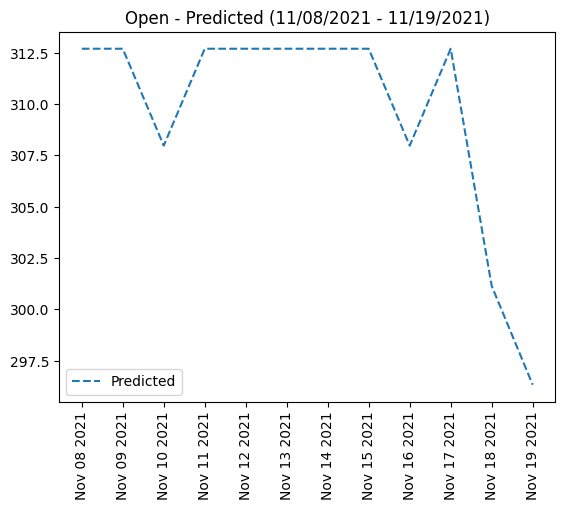

In [57]:
prediction_plot_feature('Open', predictions, pred_dates)

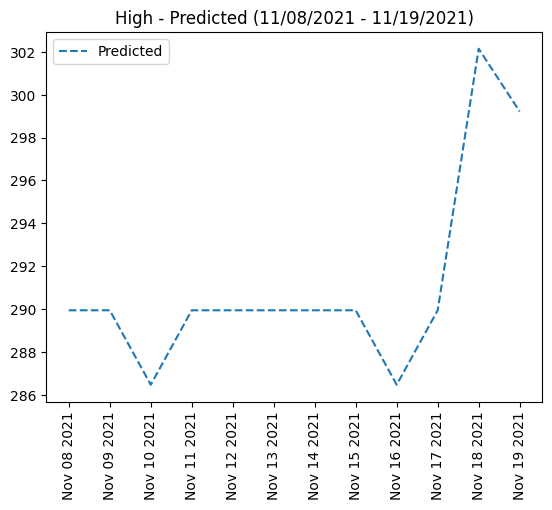

In [58]:
prediction_plot_feature('High', predictions, pred_dates)

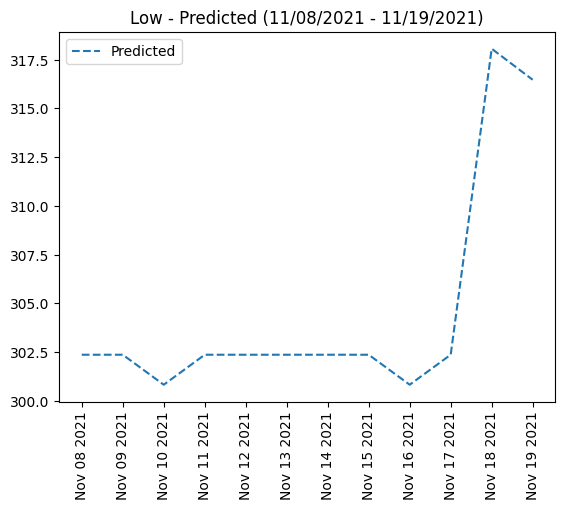

In [59]:
prediction_plot_feature('Low', predictions, pred_dates)

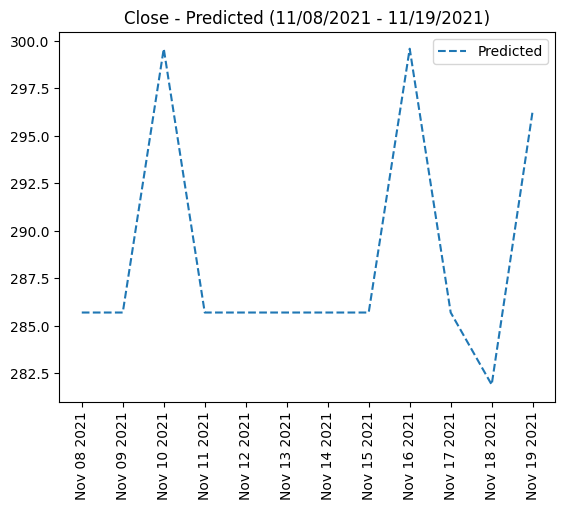

In [60]:
prediction_plot_feature('Close', predictions, pred_dates)

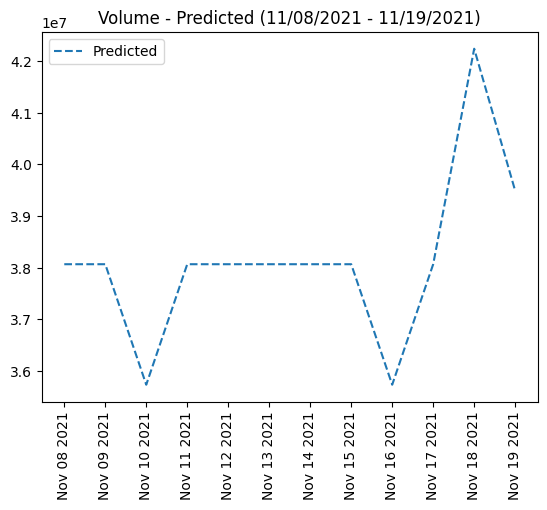

In [61]:
prediction_plot_feature('Volume', predictions, pred_dates)

#### GRU

In [62]:
pred_dates = dates_val[:21]
actual_data = df.loc[pred_dates]
predictions = predict_range(gru, pred_dates[0], pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


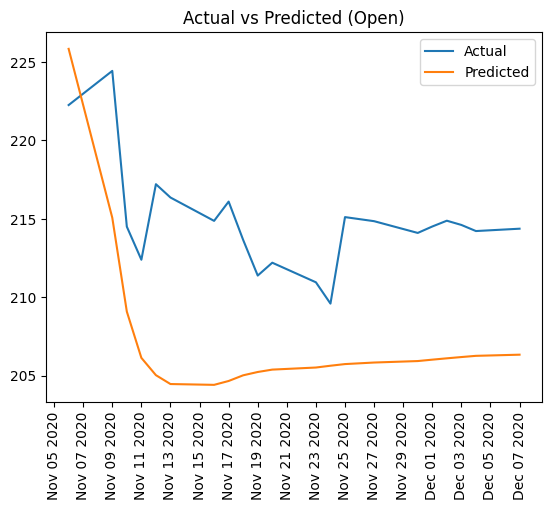

In [63]:
actual_vs_pred_plot_feature('Open', actual_data, predictions, pred_dates)

In [64]:
evaluate_predictions(actual_data, predictions, 'Open')

{'MAE': 8.091865901041668, 'MSE': 70.88972248437211}

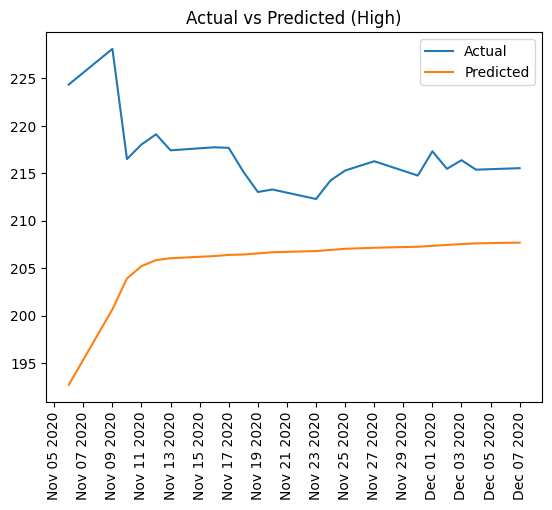

In [65]:
actual_vs_pred_plot_feature('High', actual_data, predictions, pred_dates)

In [66]:
evaluate_predictions(actual_data, predictions, 'High')

{'MAE': 11.140051650995167, 'MSE': 164.87302220876882}

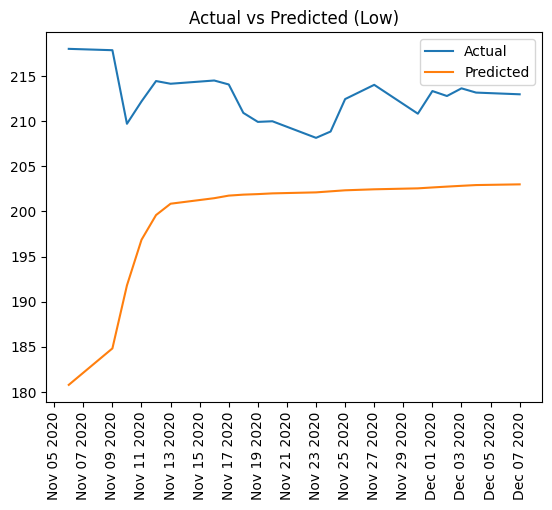

In [67]:
actual_vs_pred_plot_feature('Low', actual_data, predictions, pred_dates)

In [68]:
evaluate_predictions(actual_data, predictions, 'Low')

{'MAE': 13.175542994001116, 'MSE': 232.97729486333978}

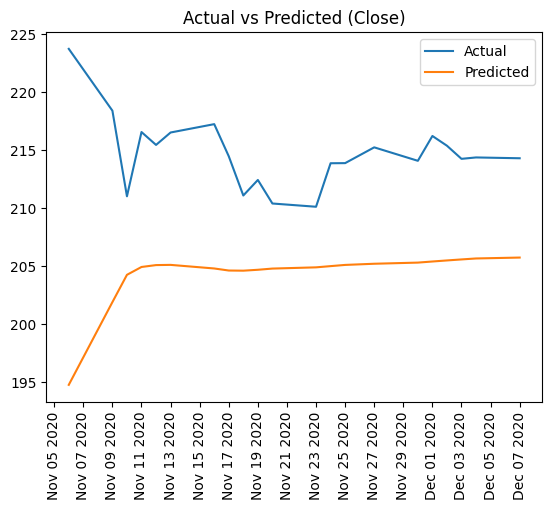

In [69]:
actual_vs_pred_plot_feature('Close', actual_data, predictions, pred_dates)

In [70]:
evaluate_predictions(actual_data, predictions, 'Close')

{'MAE': 10.288650533714657, 'MSE': 129.25226973122366}

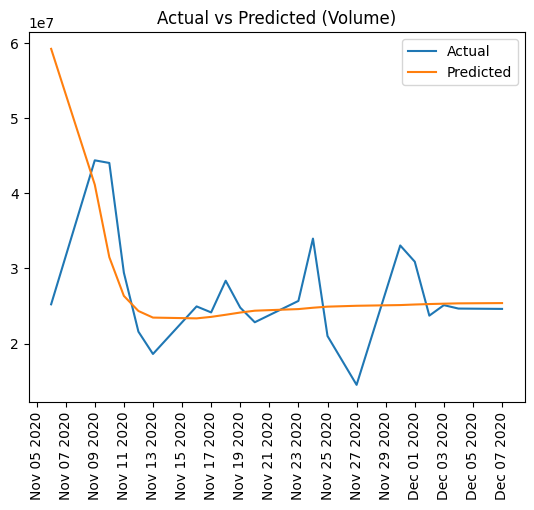

In [71]:
actual_vs_pred_plot_feature('Volume', actual_data, predictions, pred_dates)

In [72]:
evaluate_predictions(actual_data, predictions, 'Volume')

{'MAE': 5282738.952380952, 'MSE': 81022801132934.28}

In [73]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021
pred_dates = pd.bdate_range(start=df.index.max(), end="2021-11-19")
predictions = predict_range(gru, df.index.max(), pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


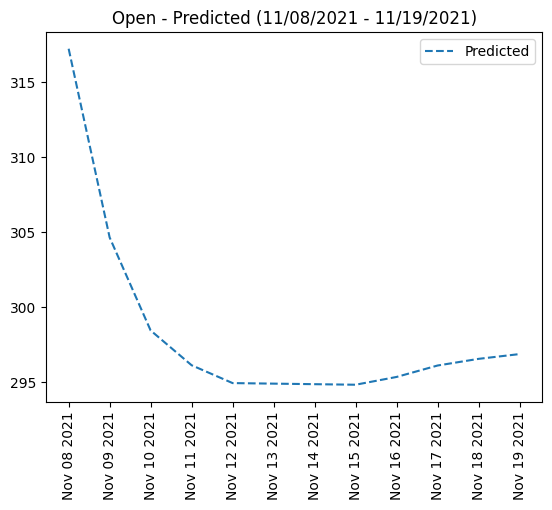

In [74]:
prediction_plot_feature('Open', predictions, pred_dates)

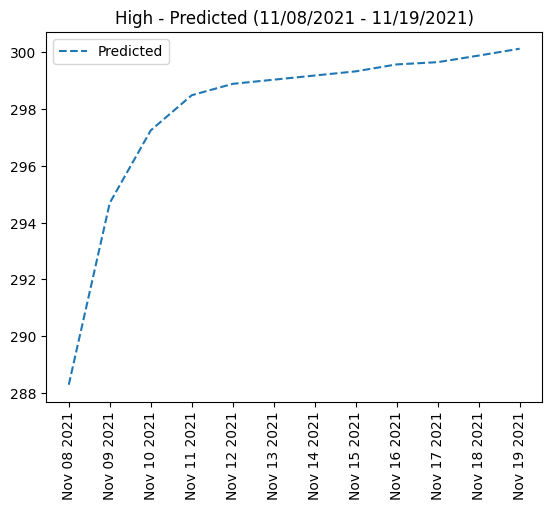

In [75]:
prediction_plot_feature('High', predictions, pred_dates)

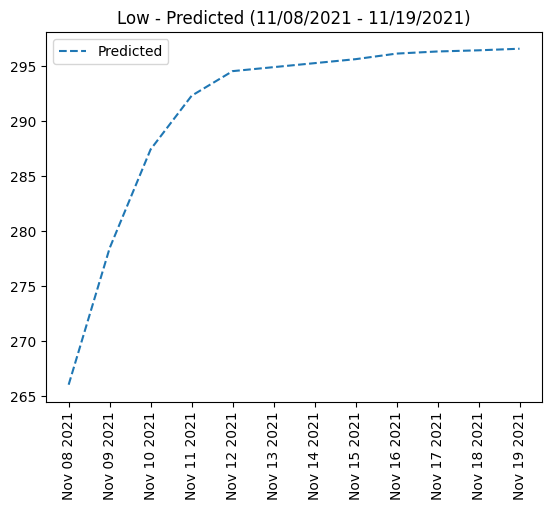

In [76]:
prediction_plot_feature('Low', predictions, pred_dates)

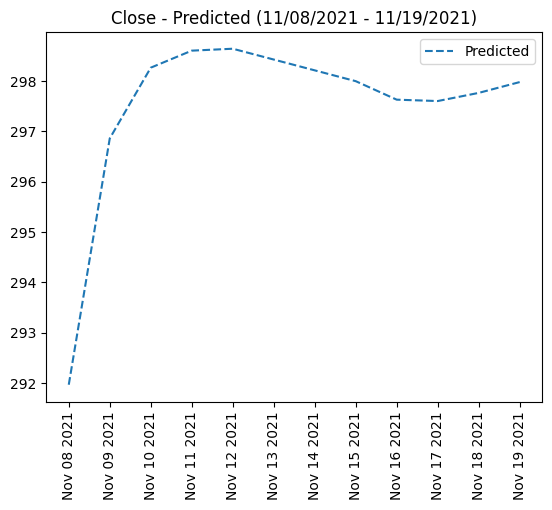

In [77]:
prediction_plot_feature('Close', predictions, pred_dates)

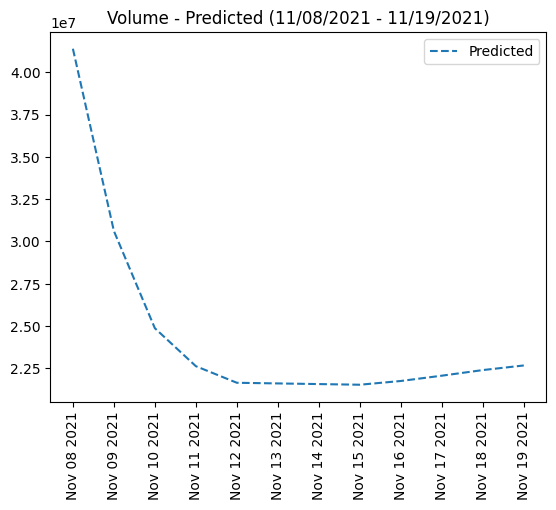

In [78]:
prediction_plot_feature('Volume', predictions, pred_dates)

#### LSTM

In [79]:
pred_dates = dates_val[:21]
actual_data = df.loc[pred_dates]
predictions = predict_range(lstm, pred_dates[0], pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


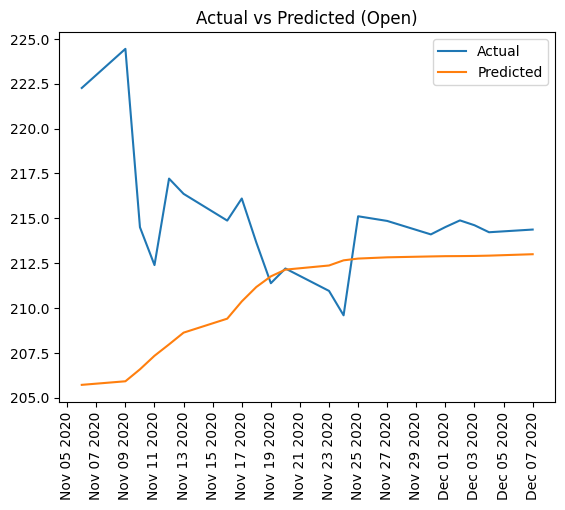

In [80]:
actual_vs_pred_plot_feature('Open', actual_data, predictions, pred_dates)

In [81]:
evaluate_predictions(actual_data, predictions, 'Open')

{'MAE': 4.630533188802083, 'MSE': 45.48162180459118}

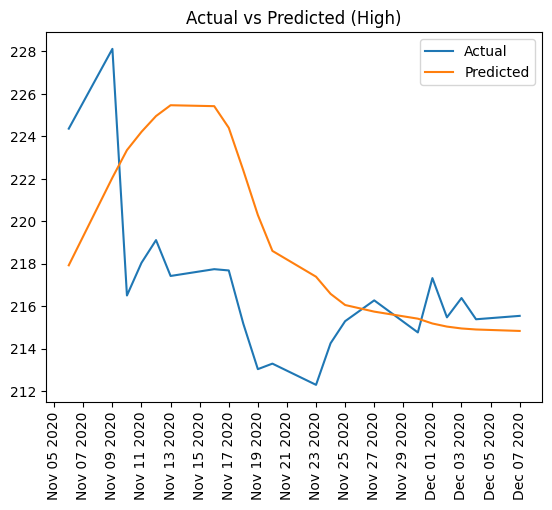

In [82]:
actual_vs_pred_plot_feature('High', actual_data, predictions, pred_dates)

In [83]:
evaluate_predictions(actual_data, predictions, 'High')

{'MAE': 4.198618568638393, 'MSE': 25.693971050800894}

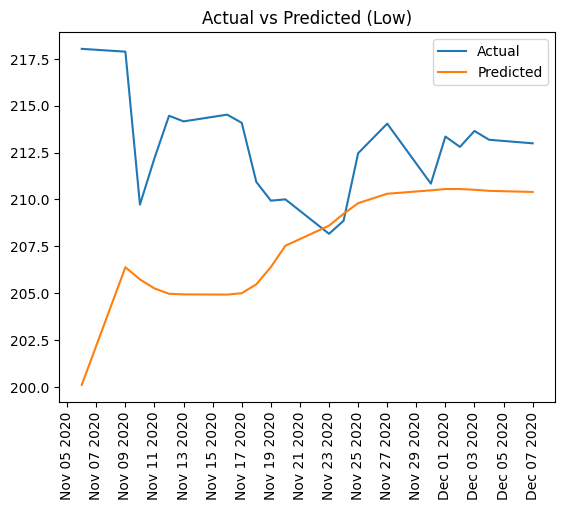

In [84]:
actual_vs_pred_plot_feature('Low', actual_data, predictions, pred_dates)

In [85]:
evaluate_predictions(actual_data, predictions, 'Low')

{'MAE': 5.2542782762741815, 'MSE': 46.42874929485307}

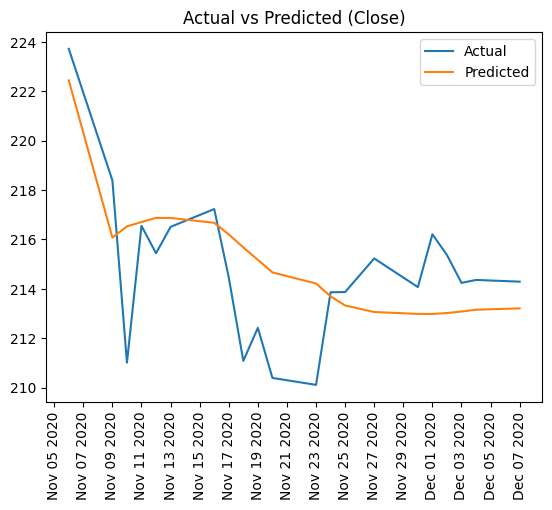

In [86]:
actual_vs_pred_plot_feature('Close', actual_data, predictions, pred_dates)

In [87]:
evaluate_predictions(actual_data, predictions, 'Close')

{'MAE': 2.0039200023716512, 'MSE': 6.33292971747165}

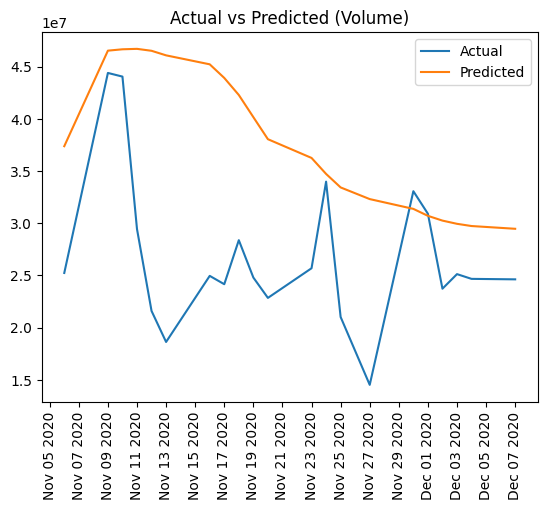

In [88]:
actual_vs_pred_plot_feature('Volume', actual_data, predictions, pred_dates)

In [89]:
evaluate_predictions(actual_data, predictions, 'Volume')

{'MAE': 11224574.666666666, 'MSE': 190241772534619.8}

In [90]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021
pred_dates = pd.bdate_range(start=df.index.max(), end="2021-11-19")
predictions = predict_range(lstm, df.index.max(), pred_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


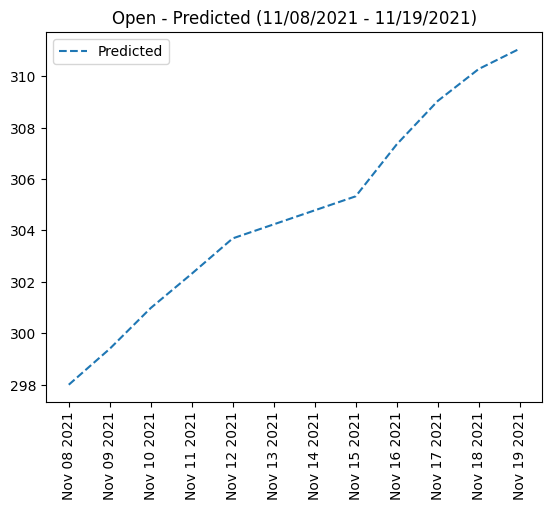

In [91]:
prediction_plot_feature('Open', predictions, pred_dates)

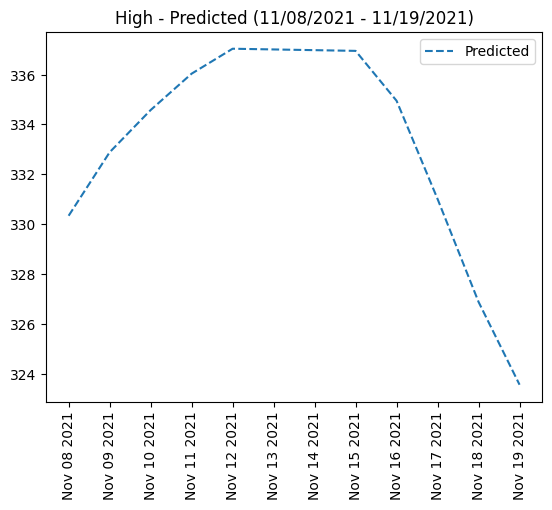

In [92]:
prediction_plot_feature('High', predictions, pred_dates)

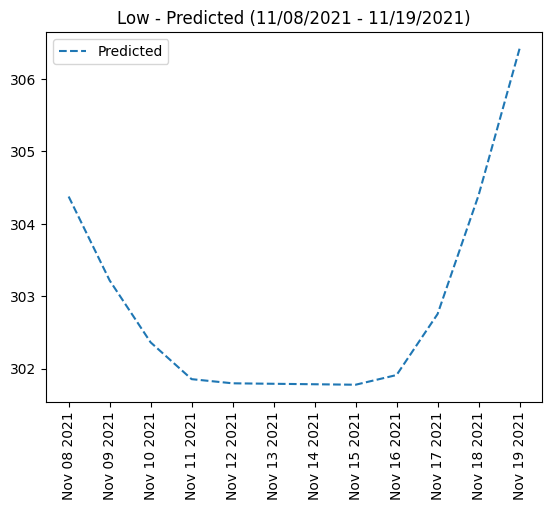

In [93]:
prediction_plot_feature('Low', predictions, pred_dates)

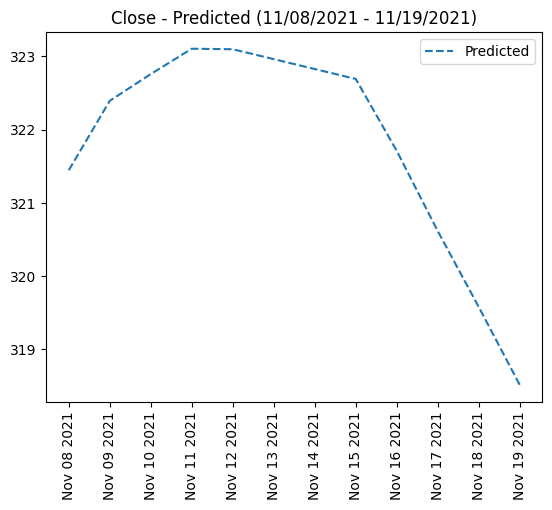

In [94]:
prediction_plot_feature('Close', predictions, pred_dates)

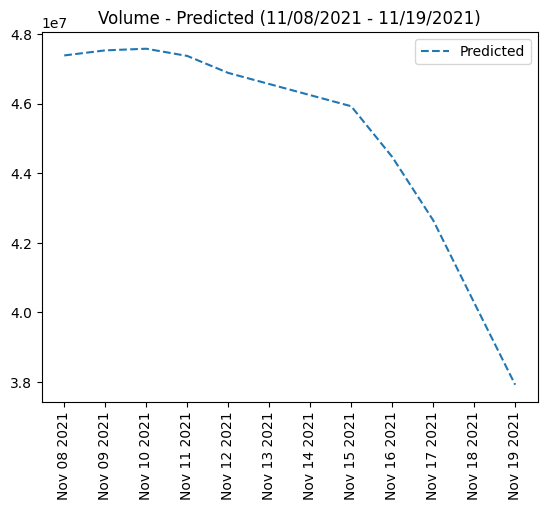

In [95]:
prediction_plot_feature('Volume', predictions, pred_dates)

## Final HTML Submission

In [97]:
!jupyter nbconvert msft_prediction.ipynb --to html

[NbConvertApp] Converting notebook msft_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 39 image(s).
[NbConvertApp] Writing 2247974 bytes to msft_prediction.html
